### Keywords extraction and visualization (W+J)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import spacy
import operator
nlp = spacy.load('en')
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize
from termcolor import colored
import re
import community
from yellowbrick.style.palettes import SEQUENCES, PALETTES, color_palette
import string
from collections import defaultdict
from collections import OrderedDict
from collections import Counter
import json

### stopwords

In [2]:
data=open('stopwords.txt','r')
data_read = data.read()
stop_words=data_read.replace('\n',' ').split()

### clean function

In [3]:
# noun_adj == True significa que filtramos unicamente sustantivos y adjetivos, en otro caso, dejamos todo salvo ...
def clean(text,noun_adj): ## filtramos unicamente los sustantivos y adjetivos
    text=re.sub("[\(\[].*?[\)\]]", "", text)
    sentences=sent_tokenize(text)
    sentences=[nlp(sentence.lower()) for sentence in sentences] ## lower() implica que se descartan los PROPN
    if noun_adj==True:
        sentences=[[(token.lemma_,token.text) for token in sentence if token.tag_=='NN' or token.tag_=='NNS' or token.tag_=='JJ'] for sentence in sentences]
    else:
        sentences=[[(token.lemma_,token.text) for token in sentence if token.lemma_ != '-PRON-' and token.is_punct==False and token.like_num==False] for sentence in sentences]
    TEXT=[item for sublist in sentences for item in sublist]
    TEXT=[(word_l,word_nl) for (word_l,word_nl) in TEXT if not word_l in stop_words or not word_nl in stop_words]
    TEXT=[(re.sub(r'[^a-zA-Z0-9]', '', word_l),word_nl) for (word_l,word_nl) in TEXT]
    TEXT=[(word_l,word_nl) for (word_l,word_nl) in TEXT if word_l.isdigit()==False and word_l!='' and word_nl.isdigit()==False and word_nl!='']
    dict_text=list(set(TEXT))
    dict_text={word_nl:word_l for (word_l,word_nl) in dict_text}
    return list(zip(*TEXT))[0],dict_text ## texto filtrado, diccionario de word original: word modificada

### ejemplo

In [4]:
text='Sequencing the Neanderthal genome (Green et al., 2010, Prüfer et al., 2014), the Denisovan genome (Reich et al., 2010), and several early modern human genomes from Eurasia (Fu et al., 2014, Fu et al., 2015) has confirmed that archaic hominins left their mark in the genomes of modern humans (Plagnol and Wall, 2006, Sankararaman et al., 2014, Vernot and Akey, 2014, Vernot et al., 2016). Present-day individuals in Eurasia inherited ∼2% of their genome from Neanderthals (Green et al., 2010), and individuals from Oceania inherited ∼5% of their genome from Denisovans (Reich et al., 2010). Suggestive evidence indicates that admixture from other unidentified hominin species occurred in Africa (Hammer et al., 2011, Hsieh et al., 2016, Lachance et al., 2012, Plagnol and Wall, 2006, Wall et al., 2009). To understand the functional, phenotypic, and evolutionary consequences of archaic admixture, it is necessary to identify the specific haplotypes and alleles that were inherited from archaic hominin ancestors (Huerta-Sánchez et al., 2014, Juric et al., 2016, Sankararaman et al., 2014, Simonti et al., 2016, Vernot and Akey, 2014). Approaches to identifying introgressed haplotypes include methods that specifically incorporate reference archaic hominin genome sequences and reference-free methods that do not utilize such information. An example of the former category is the method of Sankararaman et al. (2014), which identifies archaic haplotypes by comparing modern human haplotypes to a reference archaic sequence. The latter category of methods include the S∗ statistic (Plagnol and Wall, 2006), which searches for the mutational signature that ancient admixture leaves in the genomes of present-day humans. The S∗ approach is powerful for finding introgressed haplotypes in the absence of an archaic reference genome because it leverages the unusual mutational characteristics of introgressed haplotypes. Because of the long divergence time between Neanderthals and modern humans, Neanderthals carry many alleles that are specific to their lineage. Such alleles are present on introgressed haplotypes but are absent or rare in African genomes. Further, based on the recent timing of admixture, introgressed haplotypes are expected to be maintained without recombination over distances of approximately 50 kb on average (Sankararaman et al., 2012), resulting in high levels of linkage disequilibrium (LD) between Neanderthal-specific alleles in non-African human genomes. In this study, we develop an S∗-like method that has increased power and is suitable for large-scale genome-wide data. We apply the method to large sets of sequenced data from Eurasia and Oceania and identify putative archaic-specific alleles. We examine the rate at which these alleles match the sequenced archaic genomes and the role of the genes containing these alleles, to obtain insights into the history of the admixture events and their impact on modern human genomes.'
text_clean,dict_words=clean(text,True)


## GoW extraction

In [5]:
# K es el largo de la ventana
# text_clean es una lista de palabras de un texto ya procesado por clean
# digraph indica el tipo de grafo- True = dirigido, False = no dirigido
def GoW(text_clean,digraph=None,K=None):
    if K==None:
        K=6
    if digraph==None:
        digraph=False
    unique_words=list(set(text_clean))
    if digraph==True: ## grafo dirigido o no dirigido
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    for word in unique_words:
        G.add_node(word)
    for word in unique_words: ## recorremos el texto y encontramos los índices de todas las aparicions de word (index_word)
        index_word=[index for index, value in enumerate(text_clean) if value == word]
        ## ahora buscamos las palabras vecinas en una ventana de largo K (hacia adelante!)
        for index in index_word:
            for k in range(1,K+1):
                if index+k in range(len(text_clean)):
                    if G.has_edge(text_clean[index],text_clean[index+k])==False:
                        G.add_edge(text_clean[index],text_clean[index+k],weight=1)
                    else:
                        x=G[text_clean[index]][text_clean[index+k]]['weight']
                        G[text_clean[index]][text_clean[index+k]]['weight']=x+1
    
    return G

In [6]:
GoW(text_clean)

## GoW visualization

In [7]:
def GoW_visualization(text_clean,dict_words):
    G=GoW(text_clean)
    pos = nx.spring_layout(G)
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    labels={i:D[i] for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_size = 175,node_color='orange')
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=5,font_color='k')
    plt.axis('off')
    plt.savefig('GoW_visualization.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=1000)
    plt.show()

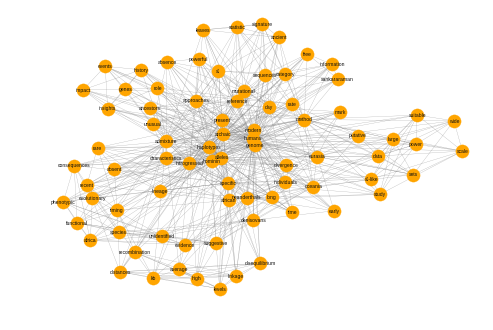

In [8]:
GoW_visualization(text_clean,dict_words)

In [9]:
def GoW_visualization_louvain(text_clean,dict_words):
    G=GoW(text_clean)
    pos = nx.spring_layout(G)
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    color_names=PALETTES['set1']#SEQUENCES['OrRd'][7]
    d = community.best_partition(G)
    if max(list(d.values())) not in range(len(color_names)): ## > 9 comunidades
        colors={x:'r' for x in list(d.keys())}
    else:
        colors={x:color_names[d[x]] for x in list(d.keys())}
    labels={i:D[i] for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_size = 175,node_color=list(colors.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=6,font_color='k')
    plt.axis('off')
    plt.savefig('GoW_visualization_louvain.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=1000)
    plt.show()

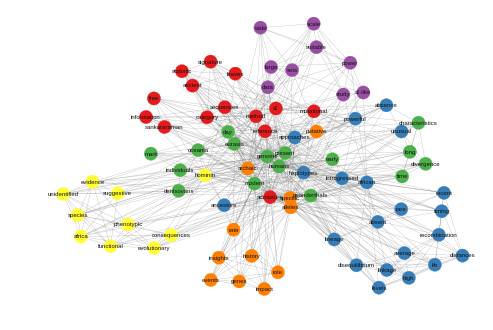

In [10]:
GoW_visualization_louvain(text_clean,dict_words)

## Main core extraction

In [13]:
def main_core_words(text_clean,dict_words,lemmatization=None):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    main_core=nx.k_core(G)
    D=dict(map(reversed, dict_words.items()))
    mc=list(main_core.nodes())
    if lemmatization==None:
        return [D[w] for w in mc]
    elif lemmatization==False:
        return mc

In [16]:
main_core_words(text_clean,dict_words)

['signature',
 'haplotypes',
 'eurasia',
 'phenotypic',
 'evolutionary',
 'modern',
 'denisovans',
 'africa',
 'consequences',
 'leaves',
 'statistic',
 'functional',
 'unidentified',
 'individuals',
 'alleles',
 'admixture',
 'method',
 'evidence',
 'ancient',
 'neanderthals',
 'sequences',
 'approaches',
 'specific',
 'present',
 'category',
 'day',
 'species',
 'hominin',
 'reference',
 'humans',
 'oceania',
 'introgressed',
 'mutational',
 'suggestive',
 's∗',
 'genome',
 'archaic']

## Main core visualization

In [22]:
def main_core_visualization(text_clean,dict_words):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    G=nx.k_core(G)
    pos = nx.spring_layout(G)
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    labels={i:D[i] for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_size = 175,node_color='orange')
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=5,font_color='k')
    plt.axis('off')
    plt.savefig('main_core_visualization.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=1000)
    plt.show()

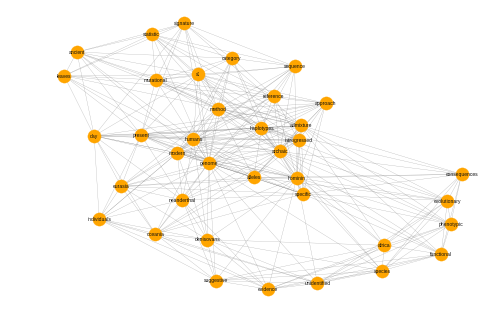

In [23]:
main_core_visualization(text_clean,dict_words)

## Main core extraction según segun Core Rank
### http://www.lix.polytechnique.fr/~anti5662/eacl_17_real_time_meladianos_tixier_nikolentzos_vazirgiannis.pdf

In [19]:
def main_core_words_core_rank(text_clean,dict_words,lemmatization=None):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    core_number=nx.core_number(G) ## core number de los nodos de G
    core_rank={word:sum([core_number[w] for w in list(dict(G[word]).keys())]) for word in list(core_number.keys())}
    main_core_nodes=list(nx.k_core(G).nodes())
    ## ahora vemos el core rank de los nodos del main core
    main_core_rank=[]
    for node in main_core_nodes:
        main_core_rank+=[(node,core_rank[node])]
    ## ordenamos segun core rank decreciente
    main_core_rank=sorted(main_core_rank, key=lambda tup: tup[1],reverse=True)
    mc=list(zip(*main_core_rank))[0]
    ## diccionario inverso!
    D=dict(map(reversed, dict_words.items()))
    
    if lemmatization==None:
        return [D[w] for w in mc]
    elif lemmatization==False:
        return mc

In [23]:
main_core_words_core_rank(text_clean,dict_words)

['genome',
 'haplotypes',
 'archaic',
 'humans',
 'admixture',
 'alleles',
 'introgressed',
 'specific',
 'method',
 'hominin',
 'modern',
 'neanderthals',
 'present',
 'reference',
 'eurasia',
 'mutational',
 's∗',
 'day',
 'oceania',
 'approaches',
 'category',
 'sequences',
 'denisovans',
 'individuals',
 'signature',
 'phenotypic',
 'evolutionary',
 'africa',
 'statistic',
 'functional',
 'unidentified',
 'evidence',
 'ancient',
 'species',
 'consequences',
 'leaves',
 'suggestive']

## n-gramas de palabras del main core

In [32]:
def main_core_ngrams(text,text_clean,dict_words,lemmatization=None):
    G=GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) 
    d=nx.core_number(G) ## diccionario de palabras asociadas a un core
    max_core=max(d.values())
    text=[w.lower() for w in word_tokenize(text)]
    c=[]
    for word in text:
        if word in dict_words.keys():
            if d[dict_words[word]]==max_core:
                if lemmatization==None:
                    c+=[word]
                elif lemmatization==False:
                    c+=[dict_words[word]]
            else:
                c+=['X']
        else:
            c+=['X']
    s=' '.join(c)
    ngrams=[token.rstrip().lstrip() for token in s.split('X') if token!=' ' and token!='']
    L=[[len(word_tokenize(token)),token] for token in ngrams]
    o = OrderedDict()
    for x in L:
        o.setdefault(x[0], []).append(x[1])
    for key in o.keys():
        if len(o[key])>1:
            o[key]=list(list(zip(*Counter(o[key]).most_common()))[0]) ## ordenamos por frecuencia
        
    return dict(o)

In [33]:
main_core_ngrams(text,text_clean,dict_words)


{1: ['alleles',
  'eurasia',
  'genomes',
  'neanderthals',
  'admixture',
  'methods',
  'method',
  'individuals',
  'genome',
  'oceania',
  'category',
  'denisovans',
  'africa',
  'functional',
  'phenotypic',
  'approaches',
  'humans',
  'mutational',
  'specific',
  'present'],
 2: ['introgressed haplotypes',
  'modern humans',
  'neanderthal genome',
  'denisovan genome',
  'archaic hominins',
  'suggestive evidence',
  'evolutionary consequences',
  'archaic admixture',
  'specific haplotypes',
  'archaic hominin',
  'archaic haplotypes',
  's∗ statistic',
  'mutational signature',
  's∗ approach',
  'human genomes',
  'archaic genomes'],
 3: ['modern human genomes',
  'unidentified hominin species',
  'modern human haplotypes',
  'reference archaic sequence',
  'ancient admixture leaves',
  'archaic reference genome'],
 5: ['reference archaic hominin genome sequences']}

## Division tripartita de un texto

In [86]:
def tripartite_words(text_clean,dict_words,lemmatization=None):
    
    G = GoW(text_clean)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos 
    main_core = nx.k_core(G)
    k_crust = nx.k_crust(G)
    Gcc = sorted(nx.connected_component_subgraphs(k_crust), key=len, reverse=True)
    G0 = Gcc[0]
    Gi = nx.union_all(Gcc[1:])
    
    try:
        mc = list(main_core.nodes())
    except AttributeError:
        mc = []
        
    try:
        G0 = list(G0.nodes())
    except AttributeError:
        G0 = []
        
    try:
        Gi = list(Gi.nodes())
    except AttributeError:
        Gi = []
    
    D = dict(map(reversed, dict_words.items()))
    
    if lemmatization == None:
        
        if len(mc)>0:
            mc = [D[w] for w in mc]
        if len(G0)>0:
            G0 = [D[w] for w in G0]
        if len(Gi)>0:
            Gi = [D[w] for w in Gi]
        
        return [mc,G0,Gi]
    
    elif lemmatization == False:
        
        return [mc,G0,Gi]

In [87]:
mc,crust,isolated=tripartite_words(text_clean,dict_words)

In [88]:
mc

['signature',
 'haplotypes',
 'eurasia',
 'phenotypic',
 'evolutionary',
 'modern',
 'denisovans',
 'africa',
 'consequences',
 'leaves',
 'statistic',
 'functional',
 'unidentified',
 'individuals',
 'alleles',
 'admixture',
 'method',
 'evidence',
 'ancient',
 'neanderthals',
 'sequences',
 'approaches',
 'specific',
 'present',
 'category',
 'day',
 'species',
 'hominin',
 'reference',
 'humans',
 'oceania',
 'introgressed',
 'mutational',
 'suggestive',
 's∗',
 'genome',
 'archaic']

In [89]:
crust

['kb',
 's∗-like',
 'scale',
 'disequilibrium',
 'african',
 'events',
 'average',
 'high',
 'role',
 'wide',
 'levels',
 'distances',
 'rare',
 'recombination',
 'study',
 'history',
 'impact',
 'lineage',
 'suitable',
 'recent',
 'power',
 'sets',
 'timing',
 'putative',
 'linkage',
 'data',
 'insights',
 'genes',
 'rate',
 'large',
 'absent']

In [90]:
isolated

['characteristics',
 'time',
 'unusual',
 'powerful',
 'absence',
 'divergence',
 'long',
 'free',
 'information',
 'sankararaman',
 'ancestors',
 'early',
 'mark']

## Visualización de división tripartita

In [105]:
def GoW_tripartite_visualization_louvain(text_clean,dict_words):
    
    G = GoW(text_clean)
    tripartite = tripartite_words(text_clean,dict_words,lemmatization=False)
    d = {}
    nodes_GoW = list(G.nodes())
    
    for node in nodes_GoW:
        if node in tripartite[0]:
            d[node]=0
            
        elif node in tripartite[1]:
            d[node]=1
        
        else:
            d[node]=2
    
    D=dict(map(reversed, dict_words.items())) ## devolvemos las palabras originales, no las lematizadas!
    
    color_names=sorted(SEQUENCES['Reds'][3])
    colors={x:color_names[d[x]] for x in list(d.keys())}
    labels={i:D[i] for i in G.nodes}
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 175,node_color=list(colors.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.75,width=0.25,edge_color='gray')
    nx.draw_networkx_labels(G,pos,labels,font_size=6,font_color='k')
    plt.axis('off')
    plt.savefig('GoW_visualization_tripartite.jpg', format='jpg', transparent=True, bbox_inches='tight',dpi=1000)
    plt.show()

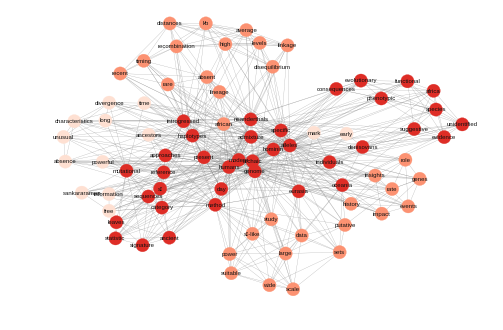

In [106]:
GoW_tripartite_visualization_louvain(text_clean,dict_words)